### Load dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re

## get SSP emissions
from tools.RCMIP import *

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


## Emulation of CMIP6 models
Here we perform the emulation of individual CMIP6 models based on our tuned carbon cycle, response, and aerosol forcing parameters.

In [2]:
## read in the response parameter values:

response_params = pd.read_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv',index_col=0)

ERFari_params = pd.DataFrame(data=np.array([[ 3.25934432e-02, -3.46653116e-04, -2.48761587e-03],
       [ 2.48231885e-02, -1.26321908e-02, -9.42090973e-04],
       [ 2.68560170e-02, -2.08950151e-03, -2.60579679e-03],
       [ 1.01700746e-01, -3.04192033e-02, -2.63868473e-03],
       [ 1.46132214e-01, -4.41485999e-02, -6.67827786e-03],
       [ 1.95732170e-03,  4.15481407e-03, -2.90822562e-03],
       [-5.61261154e-02,  8.85201623e-03, -7.47602910e-04],
       [ 3.87211606e-02, -1.42408227e-02, -1.78155606e-03],
       [ 3.02173214e-03, -3.40228173e-03, -1.25702781e-03],
       [ 2.54832726e-03,  6.32322444e-05, -2.38863636e-03]]),index=['CCCma_CanESM5_r1i1p1f1', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
       'HadGEM3-GC31-LL', 'IPSL_IPSL-CM6A-LR_r1i1p1f1', 'MIROC6', 'NorESM2-LM',
       'MOHC_UKESM1-0-LL_r1i1p1f2'],columns=['bc', 'oc', 'so2'])

### LOG so2 ERFaci params
ERFaci_params = pd.DataFrame(data=np.array([[-8.04936152e-01, -4.33765114e+00, -1.76516101e-02],
       [ 4.20348167e-01, -4.19165818e+00, -1.57827154e-02],
       [ 1.67034191e+00, -5.34562320e+00, -8.80674737e-03],
       [ 2.25088976e+00, -5.57251763e+00, -1.19361347e-02],
       [-1.80621064e+00, -4.82004944e+00, -1.88411062e-02],
       [-1.48244252e-01, -4.48450777e+00, -6.70740113e-03],
       [ 1.03705925e+00, -5.88364385e+00, -1.91422284e-03],
       [-1.00837014e+00, -4.73118298e+00, -1.30437040e-02],
       [ 2.07731610e+00, -5.03084334e+00, -1.39245898e-02],
       [-2.52178641e-01, -3.93423009e+00,  3.35367830e-03]]),index=['CCCma_CanESM5_r1i1p1f1', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
       'HadGEM3-GC31-LL', 'IPSL_IPSL-CM6A-LR_r1i1p1f1', 'MIROC6', 'NorESM2-LM',
       'MOHC_UKESM1-0-LL_r1i1p1f2'],columns=['log_beta', 'log_beta_s', 'alpha'])

fair_default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',index_col=0,skiprows=1)

In [3]:
## convert the response params to FaIR params

indep_model_list = ['CCCma_CanESM5_r1i1p1f1', 
       'CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1', 'CAMS_CAMS-CSM1-0_r1i1p1f1',
       'NOAA-GFDL_GFDL-ESM4_r1i1p1f1', 'MPI-M_MPI-ESM1-2-HR_r1i1p1f1',
       'E3SM-Project_E3SM-1-0_r1i1p1f1',
       'CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2',
       'IPSL_IPSL-CM6A-LR_r1i1p1f1', 'NOAA-GFDL_GFDL-CM4_r1i1p1f1',
       'INM_INM-CM5-0_r1i1p1f1', 'CSIRO_ACCESS-ESM1-5_r1i1p1f1',
       'MIROC_MIROC6_r1i1p1f1', 'NCAR_CESM2_r1i1p1f1',
       'MRI_MRI-ESM2-0_r1i1p1f1', 'MPI-M_MPI-ESM1-2-LR_r1i1p1f1',
       'NASA-GISS_GISS-E2-1-H_r1i1p1f1', 'CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2',
       'MOHC_HadGEM3-GC31-LL_r1i1p1f3',
       'MOHC_HadGEM3-GC31-MM_r1i1p1f3', 'BCC_BCC-ESM1_r1i1p1f1',
       'NCC_NorCPM1_r1i1p1f1', 
       'NCAR_CESM2-WACCM_r1i1p1f1', 
       'SNU_SAM0-UNICON_r1i1p1f1', 
       'MOHC_UKESM1-0-LL_r1i1p1f2', 
       'CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2',
       'NASA-GISS_GISS-E2-1-G_r1i1p1f1', 'INM_INM-CM4-8_r1i1p1f1']

def BuildMat(params):
#     param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_2x']
    A = np.array([[-1*params[0],0,0,0],\
                     [1/params[1],-1*(params[4]+params[5])/params[1],params[5]/params[1],0],\
                     [0,params[5]/params[2],-1*(params[5]+params[7]*params[6])/params[2],params[7]*params[6]/params[2]],\
                     [0,0,params[6]/params[3],-1*params[6]/params[3]]])
    k = A.shape[0]
    b = np.array([params[0],0,0,0]).T
    Q = np.zeros((4,4))
    Q[0,0] = params[8]**2
    Q[1,1] = (params[9]/params[1])**2
    A_d = sp.linalg.expm(A)
    b_d = sp.linalg.solve(A, (A_d - np.identity(k)) @ b)
    ## use Van Loan (1978) to compute the matrix exponential
    H = np.zeros((k*2,k*2))
    H[:k,:k] = -A
    H[:k,k:] = Q
    H[k:,k:] = A.T
    G = sp.linalg.expm(H)
    Q_d = G[k:,k:].T @ G[:k,k:]
    C_d = np.array([[0,1,0,0],\
                   [1,-1*params[4],(1-params[7])*params[6],-1*(1-params[7])*params[6]]])
    
    return A,b,Q,A_d,b_d,Q_d,C_d

def convert_geoffrey_to_FaIR(params):
#     ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_4x']

    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(params)
    eigval,eigvec = np.linalg.eig(A[1:,1:])
    tau = -1/eigval
    q = tau * ( eigvec[0,:] * np.linalg.inv(eigvec)[:,0] ) / params[1]
    
    return pd.DataFrame([tau,q],index=['d','q'],columns=[1,2,3])

fair_response_params = pd.concat([convert_geoffrey_to_FaIR(x.iloc[:10]) for y,x in response_params.iteritems()],axis=1,keys=response_params.columns)[indep_model_list]#.reindex([no_outlier_model_list],axis=1)

In [48]:
def forc_vals_to_f(F_2x,F_4x,PI_conc=284):
    
    f3 = (2*F_2x - F_4x) / (2 * np.sqrt(PI_conc*2) - np.sqrt(PI_conc*4) - np.sqrt(PI_conc) )
    f1 = (F_2x - f3 * (np.sqrt(PI_conc*2) - np.sqrt(PI_conc))) / np.log(2)
    return np.array([f1,f3])

In [49]:
CMIP6_cc_params = pd.read_csv('../Parameter_Sets/CMIP6_1pctCO2_cc.csv')
CMIP6_cc_params['ISM']=['MOHC_UKESM1-0-LL_r1i1p1f2','JAMSTEC','IPSL_IPSL-CM6A-LR_r1i1p1f1','BCC_BCC-ESM1_r1i1p1f1','CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2','CCCma_CanESM5_r1i1p1f1','MPI-M_MPI-ESM1-2-LR_r1i1p1f1']
CMIP6_cc_params = CMIP6_cc_params.set_index('ISM')

In [57]:
forc_vals_to_f(*response_params.loc[['F_2x','F_4x'],'CCCma_CanESM5_r1i1p1f1'])

CMIP6_cc_emulation_set = list(set(fair_response_params.columns.levels[0]).intersection(set(CMIP6_cc_params.index)))

CMIP6_gas_params = pd.concat([fair_default_params]*len(CMIP6_cc_emulation_set),axis=1,keys=CMIP6_cc_emulation_set)

for model in CMIP6_cc_emulation_set:
    
    CMIP6_gas_params.loc[['r0','rC','rT','PI_conc'],(model,'carbon_dioxide')] = CMIP6_cc_params.loc[model,['r0','rC','rT','PI_co2']].astype(float).values
    
    CMIP6_gas_params.loc[['f1','f3'],(model,'carbon_dioxide')] = forc_vals_to_f(*response_params.loc[['F_2x','F_4x'],model],CMIP6_gas_params.loc['PI_conc',(model,'carbon_dioxide')])
    
    if not model in ERFaci_params.index:
        continue
    
    for aer in ['so2','bc','oc']:
        CMIP6_gas_params.loc['f2',(model,'so2')] = ERFari_params.loc[model,'so2']
        
    CMIP6_gas_params.loc['f1',(model,'so2|aci')] = -1*np.exp(ERFaci_params.loc[model,'log_beta'])
    CMIP6_gas_params.loc['PI_conc',(model,'so2')] = np.exp(ERFaci_params.loc[model,'log_beta']) / np.exp(ERFaci_params.loc[model,'log_beta_s'])
    CMIP6_gas_params.loc['f2',(model,['bc|aci','oc|aci'])] = ERFaci_params.loc[model,'alpha']

## Idealised scenario emulation

In [7]:
## Plots of the abrupt-4x and 1pct emulations:

## get a dataframe of CO2 parameter sets:

model_list = list(response_params[indep_model_list].dropna(axis=1).columns)

CMIP6_idealised_emulation = pd.concat([fair_default_params]*len(model_list),axis=1,keys=model_list).reindex(['carbon_dioxide'],axis=1,level=1)
onepct_concs = pd.DataFrame(index=np.arange(1850,2850),columns=pd.MultiIndex.from_product([CMIP6_idealised_emulation.columns.levels[0],['carbon_dioxide']]))
abrupt4x_concs = pd.DataFrame(index=np.arange(1850,2850),columns=pd.MultiIndex.from_product([CMIP6_idealised_emulation.columns.levels[0],['carbon_dioxide']]))

for model in model_list:
    
    if model in CMIP6_cc_params.index:
    
        CMIP6_idealised_emulation.loc[['r0','rC','rT','PI_conc'],(model,'carbon_dioxide')] = CMIP6_cc_params.loc[model,['r0','rC','rT','PI_co2']].astype(float).values
        
    else:
        CMIP6_idealised_emulation.loc['PI_conc',(model,'carbon_dioxide')] = 284
    
    ## try with linear forcing relationship
#     CMIP6_idealised_emulation.loc['f1',(model,'carbon_dioxide')] = response_params.loc['F_4x',model] / np.log(4)
#     CMIP6_idealised_emulation.loc['f3',(model,'carbon_dioxide')] = 0
    
    CMIP6_idealised_emulation.loc[['f1','f3'],(model,'carbon_dioxide')] = forc_vals_to_f(*response_params.loc[['F_2x','F_4x'],model])
    
    onepct_concs.loc[:,(model,'carbon_dioxide')] = 284 * 1.01**np.arange(1,1001)
    abrupt4x_concs.loc[:,(model,'carbon_dioxide')] = CMIP6_idealised_emulation.loc['PI_conc',(model,'carbon_dioxide')] * 4

In [8]:
## run the model

onepct_emulation = run_GIR(concentrations_in=onepct_concs,gas_parameters=CMIP6_idealised_emulation,thermal_parameters=fair_response_params.reindex(model_list,axis=1,level=0))
abrupt4x_emulation = run_GIR(concentrations_in=abrupt4x_concs,gas_parameters=CMIP6_idealised_emulation,thermal_parameters=fair_response_params.reindex(model_list,axis=1,level=0))

Integrating 23 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1850 and 2849...


  0%|          | 0/999 [00:00<?, ? timestep/s]../GIR.py:252: RuntimeWarning: divide by zero encountered in true_divide
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:253: RuntimeWarning: invalid value encountered in multiply
  R_new = E[...,None] * a * 1/decay_rate * ( 1. - decay_factor ) + R_old * decay_factor
../GIR.py:252: RuntimeWarning: invalid value encountered in multiply
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
100%|██████████| 999/999 [00:00<00:00, 5314.92 timestep/s]


Integrating 23 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1850 and 2849...


100%|██████████| 999/999 [00:00<00:00, 6090.25 timestep/s]


In [9]:
## import the actual data:
abrupt_CMIP6_data = pd.read_csv('../tools/cmip6_data/abrupt-4xCO2_tas.csv',index_col=0)
onepct_CMIP6_data = pd.read_csv('../tools/cmip6_data/onepct_tas.csv',index_col=0)

CMIP6_data_onepct_emms = pd.concat([pd.read_csv('/home/leachl/Documents/Datasets/CMIP6/CMIP6_TCRE/CMIP6_TCRE/'+x,delim_whitespace=True,header=None,names=['year','E','T'],index_col=0)['E'].rename(x.split('_')[0]) for x in os.listdir('/home/leachl/Documents/Datasets/CMIP6/CMIP6_TCRE/CMIP6_TCRE') if 'data' in x],axis=1)
CMIP6_data_onepct_emms.columns = [(CMIP6_cc_params.loc[:,'CMIP6_model']==x).idxmax() for x in CMIP6_data_onepct_emms.columns]

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


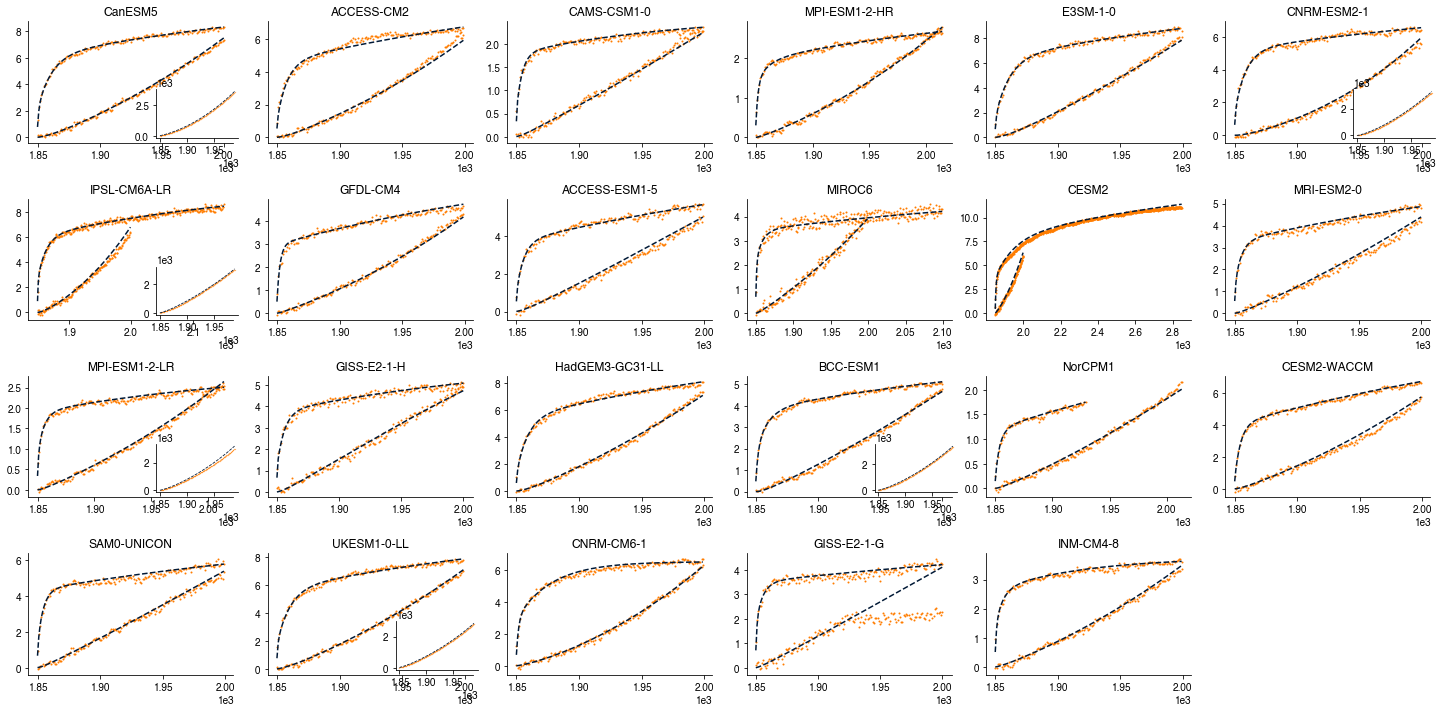

In [10]:
## create a figure

fig,ax = plt.subplots(4,6,figsize=(20,10))

emulation_color = '#011936'
CMIP_color = '#FF7D00'

for i,model in enumerate(model_list):    
    
    abrupt_plot_data = abrupt_CMIP6_data.loc[:,model].dropna().values
    ax.flatten()[i].plot(np.arange(1850,1850+abrupt_plot_data.size),abrupt_plot_data-abrupt_plot_data[:50].mean()+abrupt4x_emulation['T'].loc[1850:1899,[model]].values.mean(),'o',ms=1,c=CMIP_color)
    onepct_plot_data = onepct_CMIP6_data.loc[:,model].dropna().values
    ax.flatten()[i].plot(np.arange(1850,1850+onepct_plot_data.size),onepct_plot_data-onepct_plot_data[:50].mean()+onepct_emulation['T'].loc[1850:1899,[model]].values.mean(),'o',ms=1,c=CMIP_color)
    
    ax.flatten()[i].plot(np.arange(1850,1850+onepct_plot_data.size),onepct_emulation['T'].loc[:,[model]].values[:onepct_plot_data.size],ls='--',c=emulation_color)
    ax.flatten()[i].plot(np.arange(1850,1850+abrupt_plot_data.size),abrupt4x_emulation['T'].loc[:,[model]].values[:abrupt_plot_data.size],ls='--',c=emulation_color)
    
    ax.flatten()[i].set_title(model.split('_')[1])
    
    [ax.flatten()[i].spines[pos].set_visible(False) for pos in ['top','right']]
    
    if model in CMIP6_data_onepct_emms.columns:
        axins = inset_axes(ax.flatten()[i], width="40%", height="40%", bbox_to_anchor=(0.6,0,1,1),loc='lower left',bbox_transform=ax.flatten()[i].transAxes)
        axins.plot(CMIP6_data_onepct_emms[model],'o',color=CMIP_color,ms=0.25)
        axins.plot(onepct_emulation['Emissions'].loc[:1989,[model]].cumsum(),ls='--',color=emulation_color,lw=0.8)
        [axins.spines[pos].set_visible(False) for pos in ['top','right']]
    
ax[-1,-1].set_visible(False)

plt.tight_layout()

fig.patch.set_facecolor('white')

In [85]:
CMIP6_cc_params

,CMIP6_model,beta,gamma,r0,rC,rT,PI_co2
ISM,,,,,,,
MOHC_UKESM1-0-LL_r1i1p1f2,UKESM,0.63,1.31,37.501757,0.016319,3.577207,282.4
JAMSTEC,JAMSTEC,0.68,1.20,34.352755,0.016135,3.536897,286.9
IPSL_IPSL-CM6A-LR_r1i1p1f1,IPSL-ESM,0.95,1.00,28.627296,0.018784,4.117711,290.0
BCC_BCC-ESM1_r1i1p1f1,BCC,0.64,1.07,30.631206,0.013540,2.968220,288.9
CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2,CNRM-ESM,0.50,1.22,34.925301,0.012061,2.644004,290.2
CCCma_CanESM5_r1i1p1f1,CanESM,0.23,1.27,36.356665,0.005776,1.266088,285.5
MPI-M_MPI-ESM1-2-LR_r1i1p1f1,MPI-ESM,0.76,1.20,34.352755,0.018033,3.953003,285.9


In [58]:
## get the ssp emission sets from RCMIP
scenarios = ['ssp'+x for x in ['119','126','245','370','370-lowNTCF-aerchemmip','370-lowNTCF-gidden','434','460','534-over','585']]
ssp_emms = pd.concat([RCMIP_to_GIR_input_emms(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate()
ssp_emms -= ssp_emms.loc[1750]
ssp_forc = pd.concat([get_RCMIP_forc(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate()

In [59]:
CMIP6_FaIR_run = run_GIR(emissions_in=ssp_emms,forcing_in=ssp_forc,gas_parameters=CMIP6_gas_params,thermal_parameters=fair_response_params.reindex(CMIP6_gas_params.columns.levels[0],axis=1,level=0))

Integrating 10 scenarios, 6 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|strat_o3', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1

100%|██████████| 750/750 [00:00<00:00, 1161.70 timestep/s]


In [60]:
## get the actual historical / ssp data:

ssp_CMIP6_data = pd.read_csv('../tools/cmip6_data/ssp_tas.csv')
hist_CMIP6_data = pd.read_csv('../tools/cmip6_data/historical_tas.csv')

ssp_CMIP6_data = ssp_CMIP6_data[[x for x in ssp_CMIP6_data.columns if '_'.join(x.split('_')[:-1]) in CMIP6_FaIR_run['T'].columns.levels[1]]]
hist_CMIP6_data = hist_CMIP6_data[[x for x in hist_CMIP6_data.columns if '_'.join(x.split('_')[:-1]) in CMIP6_FaIR_run['T'].columns.levels[1]]]

ssp_CMIP6_data = ssp_CMIP6_data.unstack().reset_index()
ssp_CMIP6_data.loc[:,'ISM'] = ssp_CMIP6_data.level_0.str.split('_',expand=True).iloc[:,:-1].apply(lambda x: '_'.join(x.dropna().astype(str).values), axis=1)
ssp_CMIP6_data.loc[:,'exp'] = ssp_CMIP6_data.level_0.str.split('_',expand=True).iloc[:,-1]
ssp_CMIP6_data = ssp_CMIP6_data.set_index(['exp','ISM','level_1'])[0].unstack(['exp','ISM'])

hist_CMIP6_data = hist_CMIP6_data.unstack().reset_index()
hist_CMIP6_data.loc[:,'ISM'] = hist_CMIP6_data.level_0.str.split('_',expand=True).iloc[:,:-1].apply(lambda x: '_'.join(x.dropna().astype(str).values), axis=1)
hist_CMIP6_data.loc[:,'exp'] = hist_CMIP6_data.level_0.str.split('_',expand=True).iloc[:,-1]
hist_CMIP6_data = hist_CMIP6_data.set_index(['exp','ISM','level_1'])[0].unstack(['exp','ISM'])

ssp_CMIP6_data.index = np.arange(2015,2301)
hist_CMIP6_data.index = np.arange(1850,2030)

ssp_CMIP6_data = ssp_CMIP6_data.reindex(np.arange(1850,2301))

for ISM in ssp_CMIP6_data.columns.levels[1]:
    for ssp in ssp_CMIP6_data.columns.levels[0]:
        ssp_CMIP6_data.loc[1850:2014,(ssp,ISM)] = hist_CMIP6_data[('historical',ISM)].dropna()

# CMIP6_data = pd.concat([hist_CMIP6_data,ssp_CMIP6_data],axis=1)

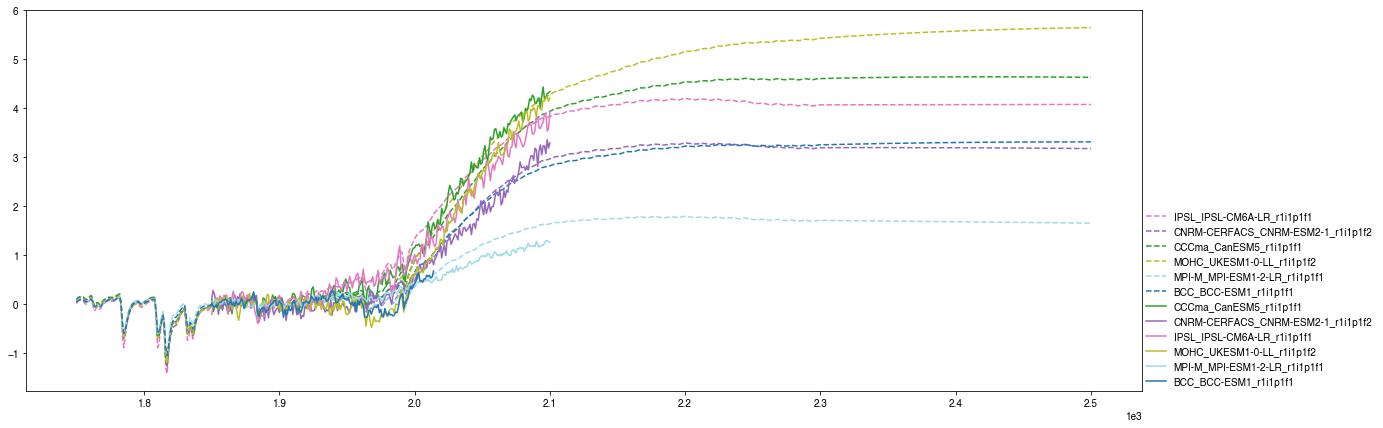

In [61]:
colors = dict(zip(CMIP6_FaIR_run['T'].columns.levels[1],matplotlib.cm.tab20(np.linspace(0,1,CMIP6_FaIR_run['T'].columns.levels[1].size))))

fig,ax = plt.subplots(figsize=(20,7))

(CMIP6_FaIR_run['T'].loc[:,'esm-ssp245-allGHG']-CMIP6_FaIR_run['T'].loc[1850:1900,'esm-ssp245-allGHG'].mean()).plot(ax=ax,legend=False,ls='--',color=[colors.get(x, '#333333') for x in CMIP6_FaIR_run['T'].loc[:,'esm-ssp245-allGHG'].columns])
(ssp_CMIP6_data.loc[:,'ssp245']-ssp_CMIP6_data.loc[1850:1900,'ssp245'].mean()).plot(ax=ax,ls='-',color=[colors.get(x, '#333333') for x in ssp_CMIP6_data.loc[:,'ssp245'].columns])
plt.legend(loc=(1,0))

In [62]:
## let's try a concentration-driven run...

ssp_concs = pd.concat([RCMIP_to_GIR_input_concs(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate()

conc_species_list = ['bc', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc11', 'cfc113', 'cfc114', 'cfc115', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'co', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nh3', 'nitrous_oxide', 'nmvoc', 'nox', 'nox_avi', 'oc', 'sf6', 'so2', 'so2f2']

## we now need to add in the aerosol emissions:
for species in ['bc', 'co', 'nh3', 'nmvoc', 'nox', 'nox_avi', 'oc', 'so2']:
    for ssp in ssp_concs.columns.levels[0]:
        emms = ssp_emms.loc[:,(ssp,species)]
        ssp_concs.loc[emms.index,(ssp,species)] = emms.values
        
ssp_concs = ssp_concs.dropna(axis=1,how='all').dropna().reindex(conc_species_list,axis=1,level=1)

In [63]:
CMIP6_FaIR_run_conc_driven = run_GIR(concentrations_in=ssp_concs,forcing_in=ssp_forc,gas_parameters=CMIP6_gas_params.reindex([x for x in CMIP6_gas_params.columns.levels[-1] if not 'halon1202' in x],axis=1,level=1),thermal_parameters=fair_response_params.reindex(CMIP6_gas_params.columns.levels[0],axis=1,level=0),aer_concs_in=['bc', 'co', 'nh3', 'nmvoc', 'nox', 'nox_avi', 'oc', 'so2'])

Integrating 10 scenarios, 6 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|strat_o3', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3'

100%|██████████| 750/750 [00:01<00:00, 485.85 timestep/s]


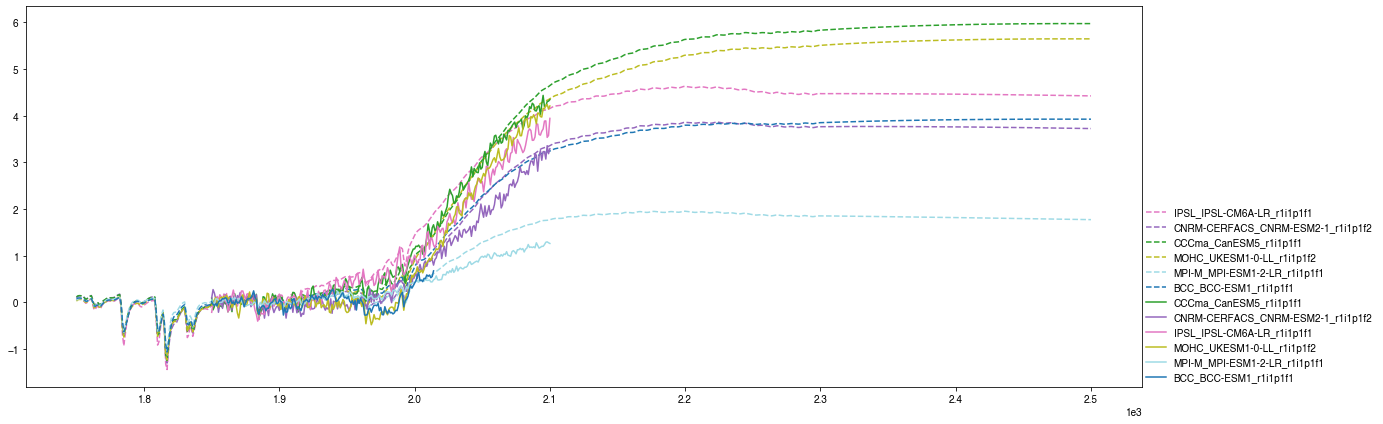

In [64]:
colors = dict(zip(CMIP6_FaIR_run['T'].columns.levels[1],matplotlib.cm.tab20(np.linspace(0,1,CMIP6_FaIR_run_conc_driven['T'].columns.levels[1].size))))

fig,ax = plt.subplots(figsize=(20,7))

(CMIP6_FaIR_run_conc_driven['T'].loc[:,'esm-ssp245-allGHG']-CMIP6_FaIR_run_conc_driven['T'].loc[1850:1900,'esm-ssp245-allGHG'].mean()).plot(ax=ax,legend=False,ls='--',color=[colors.get(x, '#333333') for x in CMIP6_FaIR_run['T'].loc[:,'esm-ssp245-allGHG'].columns])
(ssp_CMIP6_data.loc[:,'ssp245']-ssp_CMIP6_data.loc[1850:1900,'ssp245'].mean()).plot(ax=ax,ls='-',color=[colors.get(x, '#333333') for x in ssp_CMIP6_data.loc[:,'ssp245'].columns])
plt.legend(loc=(1,0))